In [1]:
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# native
import os

# modules
from utils import *
from dataset import *
from resnet50min import *
from plotgrid import PlotGrid
from score import *
from trainer import *
from logger import *

# pytorch
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms


In [2]:
requirements = {
    torch: '1'
}

check_requirements(requirements)

In [3]:
cuda = torch.cuda.is_available() and False

if cuda:
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

device = 'cuda' if cuda else 'cpu'

device

'cpu'

In [5]:
ROOT_PATH = pathJoin(os.sep, 'var', 'node433', 'local', 'gulfaraz')

In [6]:
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

imagenet_normalization_values = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}

normalize = transforms.Normalize(**imagenet_normalization_values)
denormalize = DeNormalize(**imagenet_normalization_values)


def toImage(tensor_image):
    return toPILImage(denormalize(tensor_image))

raw_transforms = transforms.Compose([
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE[0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    normalize
])

def load_data(dataset_name, split):
    dataset_path = os.path.join(ROOT_PATH, 'datasets', dataset_name)

    istrain = split == 'train'
    transforms = train_transforms if istrain else test_transforms
    batch_size = TRAIN_BATCH_SIZE if istrain else TEST_BATCH_SIZE

    dataset = MiniImageNetDataset(dataset_path, split=split, transforms=transforms)#raw_transforms)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=istrain, num_workers=8)

    print('{} dataset {} has {} datapoints in {} batches'.format(split, dataset_name, len(dataset), len(loader)))

    return dataset, loader

original_train_dataset, original_train_loader = load_data('miniimagenet', 'train')
original_val_dataset, original_val_loader = load_data('miniimagenet', 'val')

stylized_train_dataset, stylized_train_loader = load_data('stylized-miniimagenet-1.0', 'train')
stylized_val_dataset, stylized_val_loader = load_data('stylized-miniimagenet-1.0', 'val')

for dataset, loader in [
    (original_train_dataset, original_train_loader),
    (original_val_dataset, original_val_loader),
    (stylized_train_dataset, stylized_train_loader),
    (stylized_val_dataset, stylized_val_loader)
]:
    print('{} Datapoints in {} Batches'.format(len(dataset), len(loader)))

dataset_names = [
    'stylized-miniimagenet-1.0', 'stylized-miniimagenet-0.9', 'stylized-miniimagenet-0.8',
    'stylized-miniimagenet-0.7', 'stylized-miniimagenet-0.6', 'stylized-miniimagenet-0.5',
    'stylized-miniimagenet-0.4', 'stylized-miniimagenet-0.3', 'stylized-miniimagenet-0.2',
    'stylized-miniimagenet-0.1', 'stylized-miniimagenet-0.0', 'miniimagenet'
]


 54%|█████▍    | 5423/10000 [00:00<00:00, 27005.16it/s]

train dataset miniimagenet has 100000 datapoints in 3125 batches


  3%|▎         | 2658/100000 [00:00<00:03, 26571.35it/s]

val dataset miniimagenet has 10000 datapoints in 313 batches


 27%|██▋       | 2723/10000 [00:00<00:00, 27229.77it/s]

train dataset stylized-miniimagenet-1.0 has 100000 datapoints in 3125 batches


100%|██████████| 10000/10000 [00:00<00:00, 26567.47it/s]

val dataset stylized-miniimagenet-1.0 has 10000 datapoints in 313 batches
100000 Datapoints in 3125 Batches
10000 Datapoints in 313 Batches
100000 Datapoints in 3125 Batches
10000 Datapoints in 313 Batches


<IPython.core.display.Javascript object>


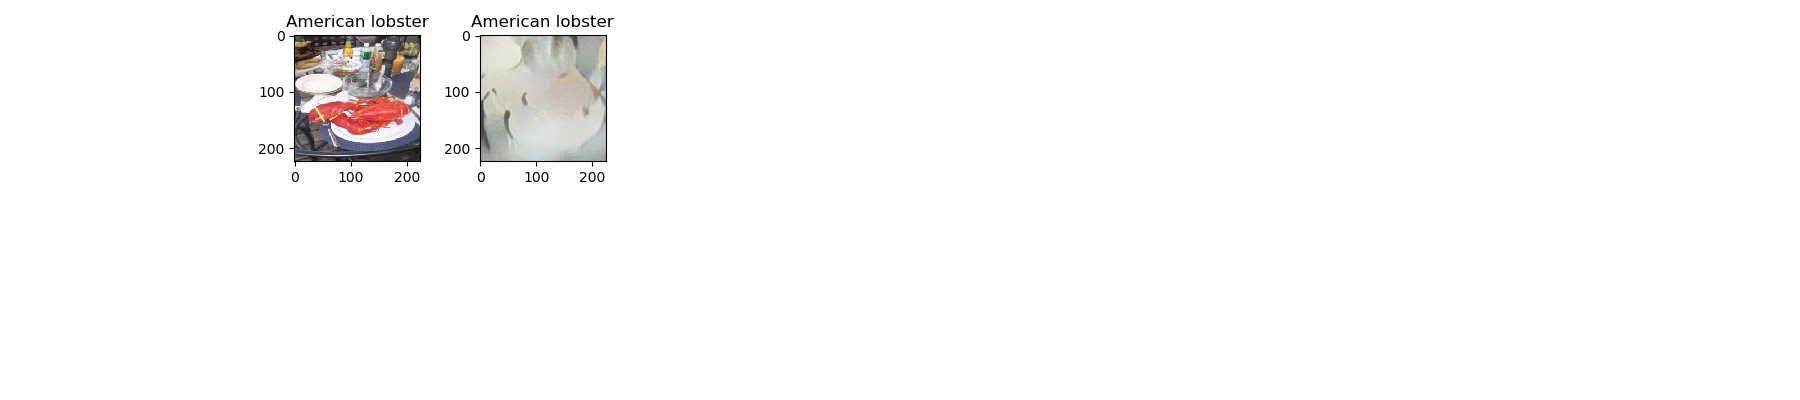

In [7]:
image_grid = PlotGrid(figsize=(9,2))

In [8]:
for index, image in enumerate(original_train_dataset):
    index_image = original_train_dataset.INDEX_IMAGE
    index_label = original_train_dataset.INDEX_LABEL
    
    # get datapoints
    original = original_train_dataset[index]
    stylized = stylized_train_dataset[index]
    
    # get images
    img = original[index_image]
    stylized_img = stylized[index_image]
    
    # plot images
    image_grid.plot((1, 2, 1), toImage(img), title=original[index_label])
    image_grid.plot((1, 2, 2), toImage(stylized_img), title=stylized[index_label])
    if (index + 1) == 9:
        break


In [9]:
supported_models = {
}

sanity(supported_models, original_train_loader, device)


resnet50_tune_fc


In [ ]:
epochs = 50

# setup log directory
log_directory = pathJoin('run_logs')
os.makedirs(log_directory, exist_ok=True)

for model_type in supported_models:

    # original
    run_name = '{}'.format(model_type)
    logger = create_logger(log_directory, run_name)
    logger.info('Run Name {}'.format(run_name))
    model = supported_models[model_type]()
    run(run_name, model, epochs, logger, original_train_loader, original_val_loader, device)

#     # stylized
#     run_name = 'stylized_{}'.format(model_type)
#     logger = create_logger(log_directory, run_name)
#     logger.info('Run Name {}'.format(run_name))
#     model = supported_models[model_type]()
#     run(run_name, model, training, epochs, monitor, logger, stylized_train_loader, stylized_val_loader)

    del model
    torch.cuda.empty_cache()


## Check Performance

In [10]:
models_directory = pathJoin(ROOT_PATH, 'models')

perf(supported_models, models_directory, dataset_names)

resnet50_tune_fc
/var/node433/local/gulfaraz/models/resnet50_tune_fc.ckpt
Checkpoint not available for model resnet50_tune_fc
